# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, r2_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 

## Подготовка данных

Прочитаем данные:

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Признаки:**  
- `RowNumber` — индекс строки в данных  
- `CustomerId` — уникальный идентификатор клиента  
- `Surname` — фамилия  
- `CreditScore` — кредитный рейтинг  
- `Geography` — страна проживания  
- `Gender` — пол  
- `Age` — возраст  
- `Tenure` — сколько лет человек является клиентом банка  
- `Balance` — баланс на счёте  
- `NumOfProducts` — количество продуктов банка, используемых клиентом  
- `HasCrCard` — наличие кредитной карты  
- `IsActiveMember` — активность клиента  
- `EstimatedSalary` — предполагаемая зарплата  

**Целевой признак:**  
- `Exited` — факт ухода клиента

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Заменим пропущенные значения в признаке `Tenure` медианным значением:

In [ ]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

Удалим лишние признаки, которые явно не влияют на предсказания:

In [ ]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Преобразуем данные из текста в числовой тип используя прямое кодирование:

In [ ]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Проверим, есть ли сильная зависимость между признаками:

In [ ]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CreditScore,1.000000,-0.003965,-0.000060,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.002857
Age,-0.003965,1.000000,-0.012606,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.027544
Tenure,-0.000060,-0.012606,1.000000,-0.007535,0.011409,0.025979,-0.030681,0.010049,-0.015989,-0.003153,0.000772,0.012041
Balance,0.006268,0.028308,-0.007535,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.401110,-0.134892,0.012087
NumOfProducts,0.012238,-0.030680,0.011409,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,-0.021859
HasCrCard,-0.005458,-0.011721,0.025979,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.005766
IsActiveMember,0.025651,0.085472,-0.030681,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.022544
EstimatedSalary,-0.001384,-0.007201,0.010049,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.008112
Exited,-0.027094,0.285323,-0.015989,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.173488,-0.052667,-0.106512
Geography_Germany,0.005538,0.046897,-0.003153,0.401110,-0.010419,0.010577,-0.020486,0.010297,0.173488,1.000000,-0.332084,-0.024628


Откровенно зависимых признаков нет.

## Исследование задачи

### Разбиение данных на выборки

Разобьем данные: 60% - train set, 20% - validation set, 20% - test set:

In [ ]:
target = df['Exited']
features = df.drop(['Exited'], axis=1)

In [ ]:
features_train, features, target_train, target = train_test_split(features, target, test_size=.4, random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features, target, test_size=.5, random_state=12345, stratify=target)

In [ ]:
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


### Масштабирование

Масштабируем признаки (стандартизируем):

In [ ]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,-1.040434,0.953312,0.360600,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-0.002786,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.087371,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,-0.002786,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.456328,0.879129,-0.914708,1,0,0.113236,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6172,-0.844611,0.381372,-0.002786,0.180068,4.292357,1,1,0.117350,1,0,1
2360,-1.359935,0.190726,-0.002786,0.547724,-0.914708,1,0,-0.192524,1,0,0
4499,-1.174418,0.476696,-0.366172,0.727840,-0.914708,0,0,0.531933,1,0,0
9162,0.155118,2.287837,-0.002786,0.449382,-0.914708,1,1,-1.307769,1,0,1


### Баланс классов

Исследуем баланс классов:

In [ ]:
target_train.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

Имеется дисбаланс 80 к 20.  
Обучим модели на несбалансированной выборке и посмотрим результаты.

### Решающее дерево

Подберём лучшую глубину на валидационной выборке и выведем время обучения:

In [ ]:
%%time

best_tree_model = None
best_depth = 0
best_f1_tree = 0
best_auc_roc_tree = 0

for depth in range(2, 21):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=555).fit(features_train, target_train)
    tree_predictions = model_tree.predict(features_valid)
    f1_tree_score = f1_score(target_valid, tree_predictions)

    probabilities_test = model_tree.predict_proba(features_valid)
    probabilities_one_test = probabilities_test[:, 1]
    roc_auc_score_tree = roc_auc_score(target_valid, probabilities_one_test)   

    if f1_tree_score > best_f1_tree:
        best_tree_model = model_tree
        best_depth = depth
        best_f1_tree = f1_tree_score
        best_auc_roc_tree = roc_auc_score_tree

print('F1-мера решающего дерева:', best_f1_tree.round(2), ', при глубине:', best_depth, ', и AUC-ROC:', best_auc_roc_tree.round(2))

F1-мера решающего дерева: 0.6 , при глубине: 7 , и AUC-ROC: 0.83
CPU times: user 464 ms, sys: 0 ns, total: 464 ms
Wall time: 470 ms


### Случайный лес
Подберём глубину и количество деревьев и выведем результаты на валидационной выборке:

In [ ]:
%%time

best_forest_model = None
best_depth = 0
best_est = 0
best_f1_forest = 0
best_auc_roc_forest = 0

for est in range(10, 101, 10):
    for depth in range(2, 21):
        model_forest = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=555).fit(features_train, target_train)
        forest_predictions = model_forest.predict(features_valid)
        f1_forest_score = f1_score(target_valid, forest_predictions)

        probabilities_test = model_forest.predict_proba(features_valid)
        probabilities_one_test = probabilities_test[:, 1]
        roc_auc_score_forest = roc_auc_score(target_valid, probabilities_one_test)  
    
        if f1_forest_score > best_f1_forest:
            best_forest_model = model_forest
            best_depth = depth
            best_est = est
            best_f1_forest = f1_forest_score
            best_auc_roc_forest = roc_auc_score_forest
        
print('F1-мера случайного леса:', best_f1_forest.round(2),
    'при глубине:', best_depth, 'и количестве деревьев:', best_est, ', и AUC-ROC:', best_auc_roc_forest.round(2))

F1-мера случайного леса: 0.63 при глубине: 17 и количестве деревьев: 60 , и AUC-ROC: 0.86
CPU times: user 57.9 s, sys: 179 ms, total: 58 s
Wall time: 58.6 s


### Логическая регрессия

In [ ]:
%%time

model_regression = LogisticRegression(random_state=555, solver='liblinear').fit(features_train, target_train)
reg_predictions = model_regression.predict(features_valid)
f1_reg_score = f1_score(target_valid, reg_predictions)

probabilities_test = model_regression.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_reg_score = roc_auc_score(target_valid, probabilities_one_test)  

print('F1-мера логистической регресии:', f1_reg_score.round(2), 'AUC-ROC:', roc_auc_reg_score.round(2))

F1-мера логистической регресии: 0.31 AUC-ROC: 0.79
CPU times: user 54.4 ms, sys: 36.1 ms, total: 90.5 ms
Wall time: 57.4 ms


### Тестрирование несбалансированных моделей


F1-мера решающего дерева на тестовой выборке: 0.5542
AUC-ROC Score: 0.4752


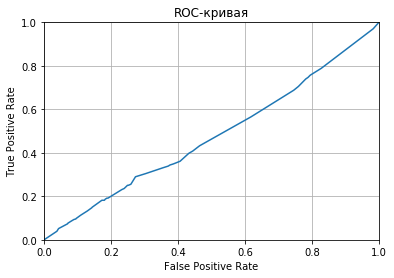

In [ ]:
test_tree_predictions = best_tree_model.predict(features_test)
print('F1-мера решающего дерева на тестовой выборке:', f1_score(target_test, test_tree_predictions).round(4))
probabilities_test = best_tree_model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
print('AUC-ROC Score:', roc_auc_score(target_test, probabilities_one_test).round(4))

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.plot(fpr, tpr)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

F1-мера случайного леса на тестовой выборке: 0.5485
AUC-ROC Score: 0.4889


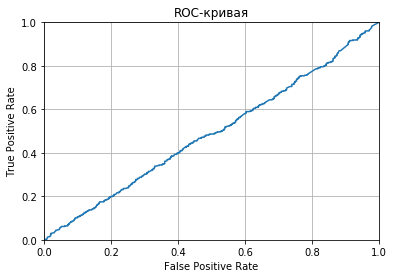

In [ ]:
test_forest_predictions = best_forest_model.predict(features_test)
print('F1-мера случайного леса на тестовой выборке:', f1_score(target_test, test_forest_predictions).round(4))
probabilities_test = best_forest_model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
print('AUC-ROC Score:', roc_auc_score(target_test, probabilities_one_test).round(4))

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.plot(fpr, tpr)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

F1-мера логистической регрессии на тестовой выборке: 0.2932
AUC-ROC Score: 0.4994


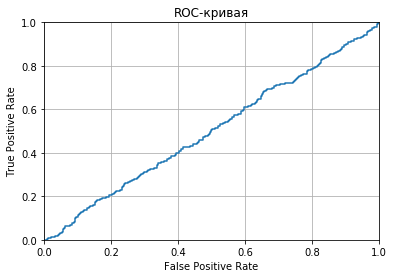

In [ ]:
test_regression_predictions = model_regression.predict(features_test)
print('F1-мера логистической регрессии на тестовой выборке:', f1_score(
    target_test, test_regression_predictions).round(4))
probabilities_test = model_regression.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
print('AUC-ROC Score:', roc_auc_score(target_test, probabilities_one_test).round(4))

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.plot(fpr, tpr)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

На тестовой выборке лучший результат показала модель Решающее дерево: F1 - `0.5542`, AUC-ROC - `0.4752`.  
Случайный лес: F1 - `0.5485`, AUC-ROC - `0.4889`; логическая регрессия: F1 - `0.2932`, AUC-ROC - `0.4994`.  

Целевый показатель в F1 - `0.59` не достигнут, требуется работа с дисбалансом.  
Стоит отметить, что ROC-кривая близка к кривой случайной модели.

## Борьба с дисбалансом

### Вспомогательные функции

Определим функцию для увеличения обучающей выборки:

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=555)
    return features_upsampled, target_upsampled

Увеличем обучающею выборку:

In [ ]:
features_train_up, target_train_up = upsample(features_train, target_train, 4)
print(features_train_up.shape)
print(target_train_up.shape)

(9666, 11)
(9666,)


Посмотрим теперь на баланс:

In [ ]:
target_train_up.value_counts(normalize=True)

1    0.50569
0    0.49431
Name: Exited, dtype: float64

Выборка сбалансирована

Определим функцию для уменьшения обучающей выборки:

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=555)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=555)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=555)
    return features_downsampled, target_downsampled

Применим функцию и посмотрим на распределение:

In [ ]:
features_train_down, target_train_down = downsample(features_train, target_train, 0.25)
print(features_train_down.shape)
print(target_train_down.shape)

(2416, 11)
(2416,)


In [ ]:

target_train_down.value_counts(normalize=True)

1    0.505795
0    0.494205
Name: Exited, dtype: float64

Выборка сбалансирована

### Решающее дерево

Обучим методом взвешивания классов:

In [ ]:
%%time

best_tree_model_balanced = None
best_depth = 0
best_f1_tree = 0
best_auc_roc_tree = 0

for depth in range(2, 21):
    model_tree = DecisionTreeClassifier(
        max_depth=depth, class_weight='balanced', random_state=555).fit(features_train, target_train)
    
    tree_predictions = model_tree.predict(features_valid)
    
    f1_tree_score = f1_score(target_valid, tree_predictions)

    probabilities_test = model_tree.predict_proba(features_valid)
    probabilities_one_test = probabilities_test[:, 1]
    roc_auc_score_tree = roc_auc_score(target_valid, probabilities_one_test)
    
    if f1_tree_score > best_f1_tree:
        best_tree_model_balanced = model_tree
        best_depth = depth
        best_f1_tree = f1_tree_score
        best_auc_roc_tree = roc_auc_score_tree

print('F1-мера решающего дерева:', best_f1_tree.round(4), 'при глубине:', best_depth, ', и AUC-ROC:', best_auc_roc_tree.round(4))

F1-мера решающего дерева: 0.5754 при глубине: 6 , и AUC-ROC: 0.8227
CPU times: user 462 ms, sys: 3.96 ms, total: 466 ms
Wall time: 472 ms


Обучим на увеличенной выборке:

In [ ]:
%%time

best_tree_model_upsampled = None
best_depth = 0
best_f1_tree = 0
best_auc_roc_tree = 0

for depth in range(2, 21):
    model_tree = DecisionTreeClassifier(
        max_depth=depth, random_state=555).fit(features_train_up, target_train_up)
    
    tree_predictions = model_tree.predict(features_valid)
    
    f1_tree_score = f1_score(target_valid, tree_predictions)

    probabilities_test = model_tree.predict_proba(features_valid)
    probabilities_one_test = probabilities_test[:, 1]
    roc_auc_score_tree = roc_auc_score(target_valid, probabilities_one_test)
    
    if f1_tree_score > best_f1_tree:
        best_tree_model_upsampled = model_tree
        best_depth = depth
        best_f1_tree = f1_tree_score
        best_auc_roc_tree = roc_auc_score_tree
        
print('F1-мера решающего дерева:', best_f1_tree.round(4), 'при глубине:', best_depth, ', и AUC-ROC:', best_auc_roc_tree.round(4))

F1-мера решающего дерева: 0.5754 при глубине: 6 , и AUC-ROC: 0.8227
CPU times: user 597 ms, sys: 0 ns, total: 597 ms
Wall time: 607 ms


Обучим на уменьшенной выборке:

In [ ]:
%%time

best_tree_model_downsampled = None
best_depth = 0
best_f1_tree = 0
best_auc_roc_tree = 0
best_auc_roc_tree = 0

for depth in range(2, 21):
    model_tree = DecisionTreeClassifier(
        max_depth=depth, random_state=555).fit(features_train_down, target_train_down)
    
    tree_predictions = model_tree.predict(features_valid)
    
    f1_tree_score = f1_score(target_valid, tree_predictions)

    probabilities_test = model_tree.predict_proba(features_valid)
    probabilities_one_test = probabilities_test[:, 1]
    roc_auc_score_tree = roc_auc_score(target_valid, probabilities_one_test)
 
    if f1_tree_score > best_f1_tree:
        best_tree_model_downsampled = model_tree
        best_depth = depth
        best_f1_tree = f1_tree_score
        best_auc_roc_tree = roc_auc_score_tree

print('F1-мера решающего дерева:', best_f1_tree.round(4), 'при глубине:', best_depth, ', и AUC-ROC:', best_auc_roc_tree.round(4))

F1-мера решающего дерева: 0.5753 при глубине: 5 , и AUC-ROC: 0.8328
CPU times: user 224 ms, sys: 3.94 ms, total: 228 ms
Wall time: 230 ms


Результаты обучение с балансированными классами алгоритмов Решающее дерево, показало примерно одинаковые результаты с F1-мера ~ `0.57` и AUC-ROC ~ `0.82`, при этом на уменьшенной выборке с меньшем временем обучения.

### Случайный лес

Обучим методом взвешивания классов:

In [ ]:
%%time

best_forest_model_balanced = None
best_depth = 0
best_est = 0
best_f1_forest = 0
best_auc_roc_forest = 0

for est in range(10, 101, 10):
    for depth in range(2, 21):
        
        model_forest = RandomForestClassifier(
            n_estimators=est, max_depth=depth, class_weight='balanced', random_state=555
        ).fit(features_train, target_train)
    
        forest_predictions = model_forest.predict(features_valid)
    
        f1_forest_score = f1_score(target_valid, forest_predictions)

        probabilities_test = model_forest.predict_proba(features_valid)
        probabilities_one_test = probabilities_test[:, 1]
        roc_auc_score_forest = roc_auc_score(target_valid, probabilities_one_test)  

        if f1_forest_score > best_f1_forest:
            best_forest_model_balanced = model_forest
            best_depth = depth
            best_est = est
            best_f1_forest = f1_forest_score
            best_auc_roc_forest = roc_auc_score_forest

print(
    'F1-мера случайного леса:', best_f1_forest.round(4),
    'при глубине:', best_depth, 'и количестве деревьев:', best_est, ', и AUC-ROC:', best_auc_roc_forest.round(4))

F1-мера случайного леса: 0.6492 при глубине: 7 и количестве деревьев: 30 , и AUC-ROC: 0.8693
CPU times: user 56.6 s, sys: 183 ms, total: 56.8 s
Wall time: 57.2 s


Обучим на увеличенной выборке:

In [ ]:
%%time

best_forest_model_upsampled = None
best_depth = 0
best_est = 0
best_f1_forest = 0
best_auc_roc_forest = 0

for est in range(10, 101, 10):
    for depth in range(2, 21):
        
        model_forest = RandomForestClassifier(
            n_estimators=est, max_depth=depth, random_state=555
        ).fit(features_train_up, target_train_up)
    
        forest_predictions = model_forest.predict(features_valid)
    
        f1_forest_score = f1_score(target_valid, forest_predictions)

        probabilities_test = model_forest.predict_proba(features_valid)
        probabilities_one_test = probabilities_test[:, 1]
        roc_auc_score_forest = roc_auc_score(target_valid, probabilities_one_test)  
    
        if f1_forest_score > best_f1_forest:
            best_forest_model_upsampled = model_forest
            best_depth = depth
            best_est = est
            best_f1_forest = f1_forest_score
            best_auc_roc_forest = roc_auc_score_forest

print(
    'F1-мера случайного леса:', best_f1_forest.round(4),
    'при глубине:', best_depth, 'и количестве деревьев:', best_est, ', и AUC-ROC:', best_auc_roc_forest.round(4))

F1-мера случайного леса: 0.6541 при глубине: 10 и количестве деревьев: 70 , и AUC-ROC: 0.8713
CPU times: user 1min 19s, sys: 276 ms, total: 1min 19s
Wall time: 1min 20s


Обучим на уменьшенной выборке:

In [ ]:
%%time

best_forest_model_downsampled = None
best_depth = 0
best_est = 0
best_f1_forest = 0
best_auc_roc_forest = 0

for est in range(10, 101, 10):
    for depth in range(2, 21):
        
        model_forest = RandomForestClassifier(
            n_estimators=est, max_depth=depth, random_state=555
        ).fit(features_train_down, target_train_down)
    
        forest_predictions = model_forest.predict(features_valid)
    
        f1_forest_score = f1_score(target_valid, forest_predictions)

        probabilities_test = model_forest.predict_proba(features_valid)
        probabilities_one_test = probabilities_test[:, 1]
        roc_auc_score_forest = roc_auc_score(target_valid, probabilities_one_test)  
    
        if f1_forest_score > best_f1_forest:
            best_forest_model_downsampled = model_forest
            best_depth = depth
            best_est = est
            best_f1_forest = f1_forest_score
            best_auc_roc_forest = roc_auc_score_forest

print(
    'F1-мера случайного леса:', best_f1_forest.round(4),
    'при глубине:', best_depth, 'и количестве деревьев:', best_est, ', и AUC-ROC:', best_auc_roc_forest.round(4))

F1-мера случайного леса: 0.6306 при глубине: 7 и количестве деревьев: 70 , и AUC-ROC: 0.8696
CPU times: user 33.3 s, sys: 124 ms, total: 33.4 s
Wall time: 33.7 s


Результаты обучение с балансированными классами алгоритма Случайный лес, дольше, чем у Решающего дерева, но с лучшей метрикой F1 = 0.65, при этом на уменьшенной выборке с меньшем временем обучения.

### Логистическая регрессия

Обучим методом взвешивания классов:

In [ ]:
%%time

model_regression_balanced = LogisticRegression(
    random_state=555, class_weight='balanced', solver='liblinear').fit(features_train, target_train)
reg_predictions = model_regression_balanced.predict(features_valid)
f1_reg_score = f1_score(target_valid, reg_predictions)
probabilities_test = model_regression_balanced.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_reg_score = roc_auc_score(target_valid, probabilities_one_test)  
print('F1-мера логистической регресии:', f1_reg_score.round(4), 'AUC-ROC:', roc_auc_reg_score.round(4))

F1-мера логистической регресии: 0.529 AUC-ROC: 0.7937
CPU times: user 56.3 ms, sys: 28.2 ms, total: 84.5 ms
Wall time: 69.4 ms


Обучим на увеличенной выборке:

In [ ]:
%%time
model_regression_upsampled = LogisticRegression(
    random_state=555, solver='liblinear').fit(features_train_up, target_train_up)
reg_predictions = model_regression_upsampled.predict(features_valid)
f1_reg_score = f1_score(target_valid, reg_predictions)
probabilities_test = model_regression_upsampled.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_reg_score = roc_auc_score(target_valid, probabilities_one_test)  
print('F1-мера логистической регресии:', f1_reg_score.round(4), 'AUC-ROC:', roc_auc_reg_score.round(4))

F1-мера логистической регресии: 0.5247 AUC-ROC: 0.7938
CPU times: user 62.2 ms, sys: 20.1 ms, total: 82.4 ms
Wall time: 113 ms


Обучим на уменьшенной выборке:

In [ ]:
%%time

model_regression_downsampled = LogisticRegression(
    random_state=555, solver='liblinear').fit(features_train, target_train)
reg_predictions = model_regression_downsampled.predict(features_valid)
f1_reg_score = f1_score(target_valid, reg_predictions)
probabilities_test = model_regression_downsampled.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_reg_score = roc_auc_score(target_valid, probabilities_one_test)  
print('F1-мера логистической регресии:', f1_reg_score.round(4), 'AUC-ROC:', roc_auc_reg_score.round(4))

F1-мера логистической регресии: 0.3077 AUC-ROC: 0.7875
CPU times: user 46.7 ms, sys: 36.1 ms, total: 82.8 ms
Wall time: 106 ms


Результаты обучение с балансированными классами алгоритма Логическая регрессия, быстро, но с низкой точностью. F1 = 0.53, при этом на уменьшенной выборке с F1 = 0.31. Данный алгоритм показал себя хуже всех.

## Тестирование модели

Для удобства определим функцию для вывода метрик F1 и AUC-ROC:

In [ ]:
def results(predictions, probabilities):
    probabilities_one_test = probabilities[:, 1]
    print('F1-мера решающего дерева на тестовой выборке:', f1_score(target_test, predictions).round(4))
    print('AUC-ROC Score:', roc_auc_score(target_test, probabilities_one_test).round(4))

### Решающеe дерево

Взвешивания классов:

In [ ]:
test_tree_predictions = best_tree_model_balanced.predict(features_test)
probabilities_test = best_tree_model_balanced.predict_proba(features_test)
results(test_tree_predictions, probabilities_test)

F1-мера решающего дерева на тестовой выборке: 0.5304
AUC-ROC Score: 0.8007


Увеличенная выборка:

In [ ]:
test_tree_predictions = best_tree_model_upsampled.predict(features_test)
probabilities_test = best_tree_model_upsampled.predict_proba(features_test)
results(test_tree_predictions, probabilities_test)

F1-мера решающего дерева на тестовой выборке: 0.5314
AUC-ROC Score: 0.8017


Уменьшенная выборка:

In [ ]:
test_tree_predictions = best_tree_model_downsampled.predict(features_test)
probabilities_test = best_tree_model_downsampled.predict_proba(features_test)
results(test_tree_predictions, probabilities_test)

F1-мера решающего дерева на тестовой выборке: 0.5304
AUC-ROC Score: 0.8025


На тестовой выборке модель Решающее дерево показывет примерно одни и теже метрики при балансированных классах, F1 ~ `0.53`, AUC-ROC ~ `0.8`.  
Результат нас не устраивает.

### Случайный лес

Взвешивания классов:

In [ ]:
test_forest_predictions = best_forest_model_balanced.predict(features_test)
probabilities_test = best_forest_model_balanced.predict_proba(features_test)
results(test_forest_predictions, probabilities_test)

F1-мера решающего дерева на тестовой выборке: 0.6118
AUC-ROC Score: 0.8538


Увеличенная выборка:

In [ ]:
test_forest_predictions = best_forest_model_upsampled.predict(features_test)
probabilities_test = best_forest_model_upsampled.predict_proba(features_test)
results(test_forest_predictions, probabilities_test)

F1-мера решающего дерева на тестовой выборке: 0.598
AUC-ROC Score: 0.8515


Уменьшенная выборка:

In [ ]:
test_forest_predictions = best_forest_model_downsampled.predict(features_test)
probabilities_test = best_forest_model_downsampled.predict_proba(features_test)
results(test_forest_predictions, probabilities_test)

F1-мера решающего дерева на тестовой выборке: 0.5842
AUC-ROC Score: 0.8523


Модель случайный лес показывается себя хорошо.  
При балансе взвешивания классов F1 ~ `0.61`, AUC-ROC ~ `0.86`;   
при увеличенной выборке F1 ~ `0.60`, AUC-ROC ~ `0.85`;   
немного хуже уменьшенная выборка: ~ `0.58`, ~ `0.85`.  

### Логическая регрессия

Взвешивания классов:

In [ ]:
test_logistic_predictions = model_regression_balanced.predict(features_test)
probabilities_test = model_regression_balanced.predict_proba(features_test)
results(test_logistic_predictions, probabilities_test)

F1-мера решающего дерева на тестовой выборке: 0.4752
AUC-ROC Score: 0.7542


Увеличенная выборка:

In [ ]:
test_logistic_predictions = model_regression_upsampled.predict(features_test)
probabilities_test = model_regression_upsampled.predict_proba(features_test)
results(test_logistic_predictions, probabilities_test)

F1-мера решающего дерева на тестовой выборке: 0.4782
AUC-ROC Score: 0.7542


Уменьшенная выборка:

In [ ]:
test_logistic_predictions = model_regression_downsampled.predict(features_test)
probabilities_test = model_regression_downsampled.predict_proba(features_test)
results(test_logistic_predictions, probabilities_test)

F1-мера решающего дерева на тестовой выборке: 0.2932
AUC-ROC Score: 0.7505


Метрики модели логической регрессия низкие, F1 ~ 0.47, AUC-ROC ~ 0.75.  
Для нашей задачи, является не приемлемым.

## Общий вывод

Налиучшая модель для прогназирования оттока клиентов:  
Случайный лес, с гиперпараметрами: глубиной деревьев - 9, количеством деревьев - 100.   
Такая модель позволяет получить самые высокие метрики: F1-мера: ~ `0.61` и AUC-ROC Score: ~ `0.85`.